In [1]:
cd ..

e:\GitHub\ppgc-uff-machine-learning


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
data_path = 'data/dataGPS_Floripa.xlsx'
xls = pd.ExcelFile(data_path)
xls.sheet_names

['Abr2019',
 'Ago2019',
 'Dez2018',
 'Fev2019',
 'Jan2019',
 'Jul2019',
 'Jun2019',
 'Mai2019',
 'Mar2019',
 'Nov2018',
 'Out2019',
 'Set2019',
 'Linhas']

Bus routes

In [4]:
routes = xls.parse('Linhas')
routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Linha              289 non-null    object        
 1   CodLinhaConsFênix  289 non-null    object        
 2   NomeLinha          289 non-null    object        
 3   TipoTransporte     289 non-null    object        
 4   InícioOperação     288 non-null    datetime64[ns]
 5   FimOperação        22 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 13.7+ KB


In [5]:
routes.head()

,Linha,CodLinhaConsFênix,NomeLinha,TipoTransporte,InícioOperação,FimOperação
0,D365,D-365,Sambaqui Direto,Regular,2003-08-03,NaT
1,1127,1127,Executivo Gaivotas,Executivo,2013-09-16,NaT
2,180,180,TITRI/ UFSC,Regular,2003-08-03,NaT
3,940,940,Canasvieiras/Santo Antônio via Jurerê,Regular,2003-08-03,NaT
4,153,153,Costeira do Pirajubaé,Regular,2004-03-15,NaT


### EDA and Feature Engineering

Making a general dataframe

In [6]:
list_of_dfs = []
for sheet_name in xls.sheet_names:
    if sheet_name != 'Linhas':
        list_of_dfs.append(xls.parse(sheet_name))

df = pd.concat(list_of_dfs)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2694360 entries, 0 to 221608
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   DataIni        datetime64[ns]
 1   HoraIni        object        
 2   DataFim        datetime64[ns]
 3   HoraFim        object        
 4   Sentido        object        
 5   Linha          object        
 6   NoVeículo      object        
 7   DuraçãoViagem  object        
 8   TotalGiros     int64         
 9   KmPerc         float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 226.1+ MB


In [24]:
datetime_columns = ['DataIni','DataFim']
time_columns = ['HoraIni','HoraFim']

In [7]:
df.head()

,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc
0,2019-04-17,10:20:00,2019-04-17,10:32:00,Volta,668,3309,00:12:00,0,7.031
1,2019-04-02,01:52:00,2019-04-02,02:43:00,Ida,300,300,00:51:00,2,24.754
2,2019-04-25,18:49:00,2019-04-25,19:15:00,Ida,186,312,00:26:00,9,12.119
3,2019-04-26,11:14:00,2019-04-26,11:40:00,Ida,631,3309,00:26:00,49,8.720
4,2019-04-26,19:24:00,2019-04-26,19:44:00,Ida,631,34425,00:20:00,11,8.720


In [8]:
df.isnull().sum()

DataIni          0
HoraIni          0
DataFim          0
HoraFim          0
Sentido          0
Linha            0
NoVeículo        0
DuraçãoViagem    0
TotalGiros       0
KmPerc           0
dtype: int64

No null values

Converting DuraçãoViagem to an integer column in minutes and hour

In [10]:
import re
df['DuracaoMinutes'] = df['DuraçãoViagem'].apply(lambda duracao: int(re.findall(':\d{2}:', str(duracao))[0].strip(':')) + 60*int(re.findall('\d{2}:', str(duracao))[0].strip(':')))
df.head()

,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc,DuracaoMinutes
0,2019-04-17,10:20:00,2019-04-17,10:32:00,Volta,668,3309,00:12:00,0,7.031,12
1,2019-04-02,01:52:00,2019-04-02,02:43:00,Ida,300,300,00:51:00,2,24.754,51
2,2019-04-25,18:49:00,2019-04-25,19:15:00,Ida,186,312,00:26:00,9,12.119,26
3,2019-04-26,11:14:00,2019-04-26,11:40:00,Ida,631,3309,00:26:00,49,8.720,26
4,2019-04-26,19:24:00,2019-04-26,19:44:00,Ida,631,34425,00:20:00,11,8.720,20


In [11]:
df[df.DuracaoMinutes >= 60].shape[0]*100/df.shape[0]

9.898565893199127

Almost 10% of trips takes at least one hour

In [12]:
trip_length = 120
df[df['DuracaoMinutes'] >= trip_length].shape[0]*100/df.shape[0]

0.1657536483617631

Very few trips takes at least 120 minutes, let's see if there are some routes where this duration isn't an exception

In [13]:
gt_duration = pd.crosstab(df[df['DuracaoMinutes'] >= trip_length]['Linha'], 'frequency').reset_index()
gt_duration.sort_values(by=['frequency'], ascending=False)

col_0,Linha,frequency
55,2120,267
13,1125,204
151,840,204
24,138,196
58,221,170
...,...,...
46,182,1
51,191,1
137,664,1
97,365V,1


In [14]:
gt_duration['totalTravels'] = gt_duration['Linha'].apply(lambda linha: df[df['Linha'] == linha].shape[0])
gt_duration['perctgt_duration'] = gt_duration['frequency']*100/gt_duration['totalTravels']
gt_duration.sort_values(by=['perctgt_duration'], ascending=False)

col_0,Linha,frequency,totalTravels,perctgt_duration
3,109,4,32,12.500000
101,4121,41,1017,4.031465
168,D267,42,1369,3.067933
164,D174,15,519,2.890173
56,2123,15,533,2.814259
...,...,...,...,...
34,168,1,12788,0.007820
137,664,1,13425,0.007449
69,268,1,15990,0.006254
74,276,2,34775,0.005751


It seems that, except Linha 109, trips that take at least 120 minutes are exceptions

However, some of these trips might have an usual duration a little less than 120 minutes, let's analyze it

In [16]:
gt_duration['gt_90_lt_120'] = gt_duration['Linha'].apply(lambda linha: df[(df['Linha'] == linha) & (df['DuracaoMinutes'] > 90) & (df['DuracaoMinutes'] < 120)].shape[0])
gt_duration['perct_gt_90'] = gt_duration['gt_90_lt_120']*100/gt_duration['totalTravels']
gt_duration.sort_values(by=['perct_gt_90'], ascending=False)

col_0,Linha,frequency,totalTravels,perctgt_duration,gt_90_lt_120,perct_gt_90
168,D267,42,1369,3.067933,1042,76.113952
167,D266,11,797,1.380176,391,49.058971
166,D264,18,1047,1.719198,474,45.272206
13,1125,204,16643,1.225741,4232,25.428108
3,109,4,32,12.500000,7,21.875000
...,...,...,...,...,...,...
97,365V,1,2749,0.036377,0,0.000000
110,463,1,10586,0.009446,0,0.000000
46,182,1,2588,0.038640,0,0.000000
61,260,3,32602,0.009202,0,0.000000


In [17]:
gt_duration[gt_duration['perct_gt_90'] >= 20].shape[0]

5

Very few routes consistenly take more than 90 minutes to complete its trip. It's time to remove the outliers from the data

In [20]:
def outliers_idx(df, feature):
    outliers = []
    
    quartile_1 = np.percentile(df[feature], 25)
    quartile_3 = np.percentile(df[feature], 75)

    step = 1.5 * (quartile_3 - quartile_1)
    
    feature_outliers = df[~((df[feature] >= quartile_1 - step) & (df[feature] <= quartile_3 + step))]
    
    outliers.extend(list(feature_outliers.index.values))
    
    return outliers

In [22]:
print(f"Dataset before outliers removal: {df.shape}")
outliers = outliers_idx(df, 'DuracaoMinutes')
df = df.drop(df.index[outliers]).reset_index(drop=True)
print(f"Dataset after outliers removal: {df.shape}")

Dataset before outliers removal: (2694360, 11)
Dataset after outliers removal: (2615496, 11)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615496 entries, 0 to 2615495
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DataIni         object 
 1   HoraIni         object 
 2   DataFim         object 
 3   HoraFim         object 
 4   Sentido         object 
 5   Linha           object 
 6   NoVeículo       object 
 7   DuraçãoViagem   object 
 8   TotalGiros      int64  
 9   KmPerc          float64
 10  DuracaoMinutes  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 219.5+ MB


In [32]:
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")
for col in time_columns:
    df[col] = pd.to_datetime(df[col], format="%H:%M:%S").dt.time
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615496 entries, 0 to 2615495
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   DataIni         datetime64[ns]
 1   HoraIni         object        
 2   DataFim         datetime64[ns]
 3   HoraFim         object        
 4   Sentido         object        
 5   Linha           object        
 6   NoVeículo       object        
 7   DuraçãoViagem   object        
 8   TotalGiros      int64         
 9   KmPerc          float64       
 10  DuracaoMinutes  int64         
 11  AvgSpeed        float64       
 12  PassPerKm       float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(6)
memory usage: 259.4+ MB
None


,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc,DuracaoMinutes,AvgSpeed,PassPerKm
0,2019-04-17,10:20:00,2019-04-17,10:32:00,Volta,668,3309,00:12:00,0,7.031,12,35.155000,0.000000
1,2019-04-02,01:52:00,2019-04-02,02:43:00,Ida,300,300,00:51:00,2,24.754,51,29.122353,0.080795
2,2019-04-25,18:49:00,2019-04-25,19:15:00,Ida,186,312,00:26:00,9,12.119,26,27.966923,0.742636
3,2019-04-26,11:14:00,2019-04-26,11:40:00,Ida,631,3309,00:26:00,49,8.720,26,20.123077,5.619266
4,2019-04-26,19:24:00,2019-04-26,19:44:00,Ida,631,34425,00:20:00,11,8.720,20,26.160000,1.261468


In [36]:
df['HourStart'] = pd.to_datetime(df['HoraIni'], format="%H:%M:%S").dt.hour
df['HourEnd'] = pd.to_datetime(df['HoraFim'], format="%H:%M:%S").dt.hour
df.head()

,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc,DuracaoMinutes,AvgSpeed,PassPerKm,HourStart,HourEnd
0,2019-04-17,10:20:00,2019-04-17,10:32:00,Volta,668,3309,00:12:00,0,7.031,12,35.155000,0.000000,10,10
1,2019-04-02,01:52:00,2019-04-02,02:43:00,Ida,300,300,00:51:00,2,24.754,51,29.122353,0.080795,1,2
2,2019-04-25,18:49:00,2019-04-25,19:15:00,Ida,186,312,00:26:00,9,12.119,26,27.966923,0.742636,18,19
3,2019-04-26,11:14:00,2019-04-26,11:40:00,Ida,631,3309,00:26:00,49,8.720,26,20.123077,5.619266,11,11
4,2019-04-26,19:24:00,2019-04-26,19:44:00,Ida,631,34425,00:20:00,11,8.720,20,26.160000,1.261468,19,19


In [51]:
numeric_cols = ['TotalGiros','KmPerc','DuracaoMinutes','HourStart']

### Data by Bus Line

In [197]:
aggreg = {
    'Sentido':'count',
    'TotalGiros':'sum',
    'DuracaoMinutes':'mean',
    'KmPerc':'mean'
}

info_route = df.groupby(['Linha'], as_index=False).agg(aggreg).dropna().rename(columns={"Sentido":"NumTrips","DuracaoMinutes":"MeanDuracao"})
info_route['PassPerTrip'] = info_route['TotalGiros']/info_route['NumTrips']
info_route.sort_values(by=['PassPerTrip'], ascending=False)

,Linha,NumTrips,TotalGiros,MeanDuracao,KmPerc,PassPerTrip
212,D260,251,14430,68.529880,34.176873,57.490040
216,D360,531,29968,62.073446,22.144000,56.436911
217,D360V,355,19784,61.780282,37.909699,55.729577
229,M941,920,50098,49.836957,21.298841,54.454348
94,284,1004,53437,45.347610,15.984287,53.224104
...,...,...,...,...,...,...
158,604,1,0,0.000000,22.469000,0.000000
148,560,4,0,0.500000,11.880000,0.000000
104,310,1,0,58.000000,18.220000,0.000000
63,187,13,0,0.538462,4.392077,0.000000


In [198]:
routes_most_ppt = info_route.sort_values(by=['PassPerTrip'], ascending=False).iloc[:5].Linha.unique()
routes_most_ppt

array(['D260', 'D360', 'D360V', 'M941', '284'], dtype=object)

In [199]:
routes_no_pass = info_route[info_route.TotalGiros == 0].Linha.unique()
routes_no_pass

array(['187', '301', '310', '475', '560', '604', '606', '7220'],
      dtype=object)

6 bus lines don't have any recorded passenger. Let's see if they are still working.

In [200]:
info_route = pd.merge(info_route, routes[['Linha','FimOperação']], how='left',on='Linha')
info_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Linha        230 non-null    object        
 1   NumTrips     230 non-null    int64         
 2   TotalGiros   230 non-null    int64         
 3   MeanDuracao  230 non-null    float64       
 4   KmPerc       230 non-null    float64       
 5   PassPerTrip  230 non-null    float64       
 6   FimOperação  5 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 12.7+ KB


In [203]:
info_route['FimOperação'] = info_route['FimOperação'].fillna(pd.to_datetime("1900-01-01"))

In [217]:
for route in info_route[info_route['FimOperação'] != "1900-01-01"].Linha.unique():
    print(f"Linha {route} com fim de operação em {info_route[info_route.Linha == route]['FimOperação'].values[0]}")


Linha 310 com fim de operação em 2015-07-20T00:00:00.000000000
Linha 471 com fim de operação em 2015-07-20T00:00:00.000000000
Linha 608 com fim de operação em 2015-07-20T00:00:00.000000000
Linha 659 com fim de operação em 2019-02-28T00:00:00.000000000
Linha 767 com fim de operação em 2016-06-06T00:00:00.000000000


We have four routes (310, 471, 608 and 767) which apparently stopped working before our dataset date.
Route 659 stopped working during the start and end of the dataset.
Route 310 is the only route which also appears in the list of routes with zero daily passengers.

This means that, for the rest of the bus lines with zero daily passengers, no passengers was recorded for whatever reason or there really was no passengers that day.

### Passengers by hour

In [67]:
aggreg = {
    'TotalGiros':'mean',
    'DuracaoMinutes':'mean',
    'KmPerc':'mean'
}

info_hour = df.groupby(['HourStart'], as_index=False).agg(aggreg)
info_hour.sort_values(by=['TotalGiros'], ascending=False)

,HourStart,TotalGiros,DuracaoMinutes,KmPerc
16,16,23.727759,34.515598,12.843208
6,6,23.265377,30.210435,12.891135
7,7,22.063471,32.702328,12.639573
4,4,21.936697,33.076552,17.940496
17,17,21.675957,34.899102,12.264827
11,11,21.596865,33.252440,13.095177
5,5,21.160686,26.911132,12.736849
12,12,20.777224,32.525566,12.654728
15,15,20.637479,33.079057,12.704847
14,14,17.088852,32.379132,12.818944


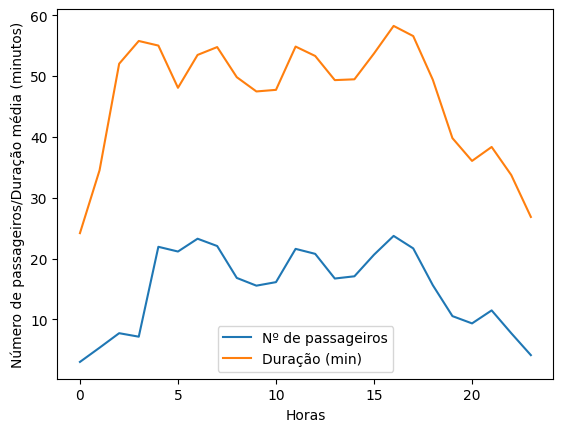

In [141]:
info_hour.plot(x="HourStart",
               y=["TotalGiros","DuracaoMinutes"],
               kind="line",
               xlabel="Horas",
               ylabel="Número de passageiros/Duração média (minutos)",
               sharex=True,
               stacked=True)
plt.legend(['Nº de passageiros','Duração (min)'])

The busiest time is between 4am and 6pm. And travel time varies with number of passengers, in general

### Looking for correlations

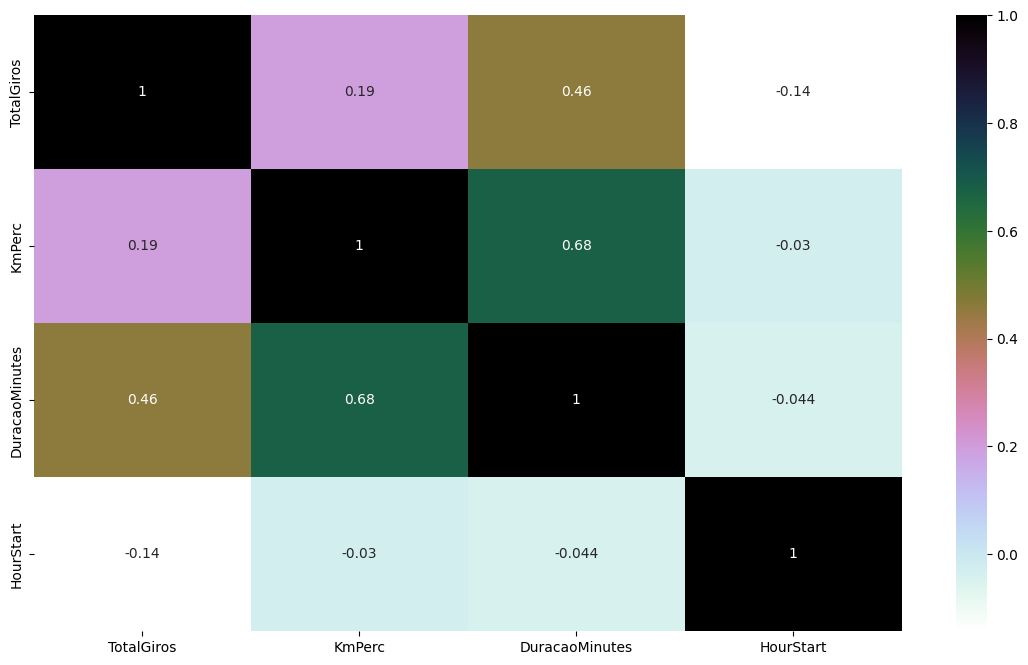

In [50]:
plt.figure(figsize=(14,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='cubehelix_r')
plt.show()

There is a clear correlation between KmPerc and DuracaoMinutes, and as we can see there is a correlation between TotalGiros and DuracaoMinutes, lets visualize it

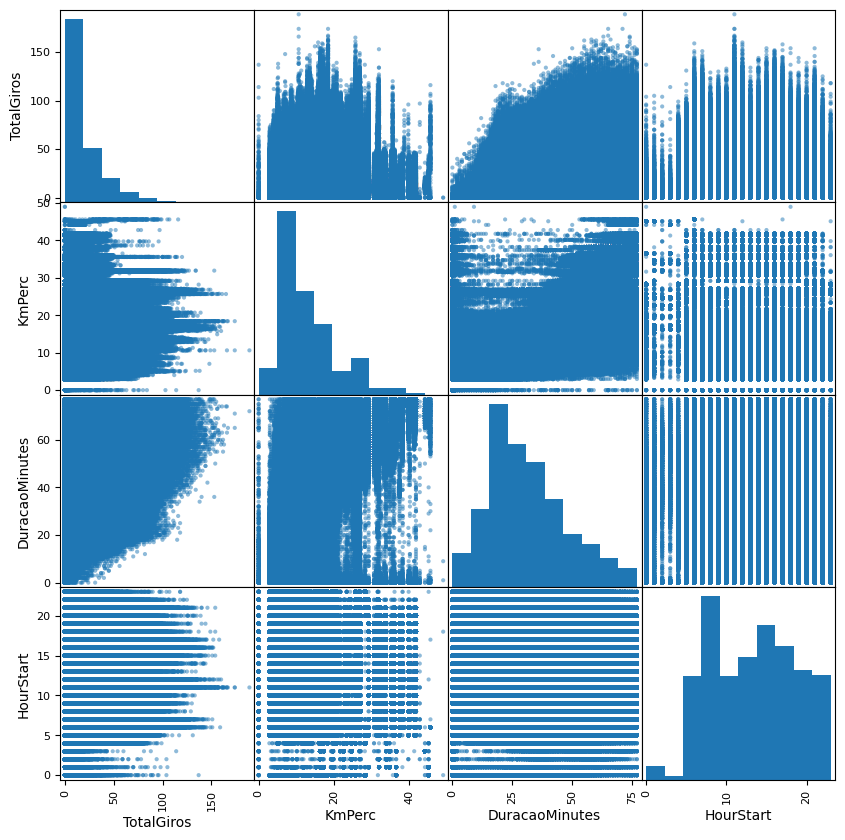

In [52]:
pd.plotting.scatter_matrix(df[numeric_cols], figsize=(10,10))
plt.show()

Makes sense that, the longer the trip, more people will get on the bus. However, just as the correlation coefficient showed, this relation isn't exatcly linear.

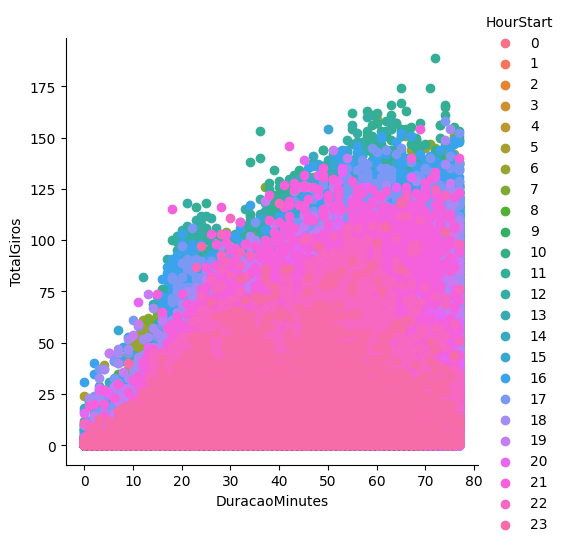

In [62]:
sns.FacetGrid(df[numeric_cols], hue="HourStart", height=5).map(plt.scatter, "DuracaoMinutes", "TotalGiros").add_legend()
plt.show()

And just as we saw before, later hours have the least TotalGiros, regardless of trip duration.

### Data by Date and Bus Line

Let's group our data by date and route so that we can take a temporal approach

In [188]:
aggreg = {
    "Sentido":"count",
    "TotalGiros":"sum",
    "DuracaoMinutes":"mean"
}
date_route = df.groupby(["DataIni","Linha"]).agg(aggreg).rename(columns={"Sentido":"NumTrips","DuracaoMinutes":"MeanDuracao"})
date_route['PassPerTrip'] = date_route['TotalGiros']/date_route['NumTrips']
date_route['Linha']=date_route.index.get_level_values(1)
date_route.info()
date_route.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 62619 entries, (Timestamp('2018-11-01 00:00:00'), '101') to (Timestamp('2019-11-01 00:00:00'), 'M273')
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NumTrips     62619 non-null  int64  
 1   TotalGiros   62619 non-null  int64  
 2   MeanDuracao  62619 non-null  float64
 3   PassPerTrip  62619 non-null  float64
 4   Linha        62619 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 2.6+ MB


NumTrips  TotalGiros  MeanDuracao  PassPerTrip Linha
DataIni    Linha                                                      
2018-11-01 101          16         129    28.375000     8.062500   101
           104          30         763    40.266667    25.433333   104
           110          64           0    22.921875     0.000000   110
           1112         38         317    38.684211     8.342105  1112
           1113         54         654    36.388889    12.111111  1113

In [189]:
date_route[date_route.TotalGiros == 0].shape[0]*100/date_route.shape[0]

2.7196218400166083

Almost 3% of daily bus routes doesn't have any recorded passenger 

In [190]:
route_no_pass = date_route[date_route.TotalGiros == 0].Linha.unique()
route_no_pass

array(['110', '210', '212', '311', '410', '166', '460', '564', '847',
       'D264', 'D267', '187', '4124', '661', '170', '330', '151V', 'D846',
       '109', '185', '767', '6120', '156', '176', 'D266', '1112', '1113',
       '1115', '1117', '186', '200', '3001', '3002', '4120', '4122',
       '4123', '4125', '6220', '760', '772', '181', '172V', '946', '766V',
       '280', '471', 'M941', '301', '659', '365V', 'D260', '848', '310',
       'D565', 'D766', '1125', '268', '461', '167', '151', '669', '7220',
       '565', '560', '566', '850', '475', '948', '284', '291', '175',
       '601V', '606', '133', '165', '168', '169', '174', '179', '183',
       '184', '262', '264', '266', '270', '272', '282', '332', '365',
       '462', '463', '630', '631', '660', '665', '670', '671', '841',
       '844', 'M273', '296', '470', '150', '604', 'D360V', '632', '283',
       '468', '845', '472', '944', '172', '184V', '265', '366', '846'],
      dtype=object)

## Time Series

Let's start analyzing the data as a time series

I will start by working on the five routes with the highest average number of passengers per trip

In [123]:
sample_data = date_route[date_route.Linha.isin(routes_most_ppt)]
sample_data = sample_data.drop(['Linha'],axis=1)
sample_data = sample_data.reset_index(level='Linha')

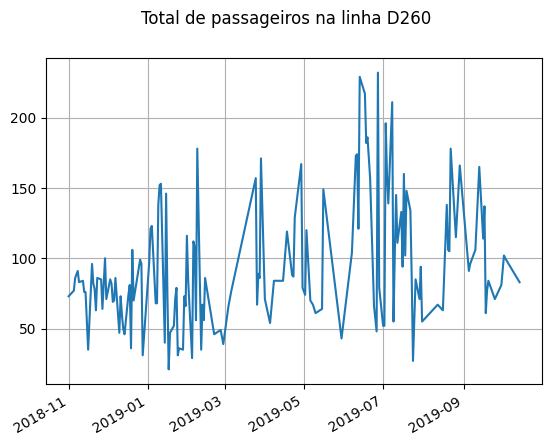

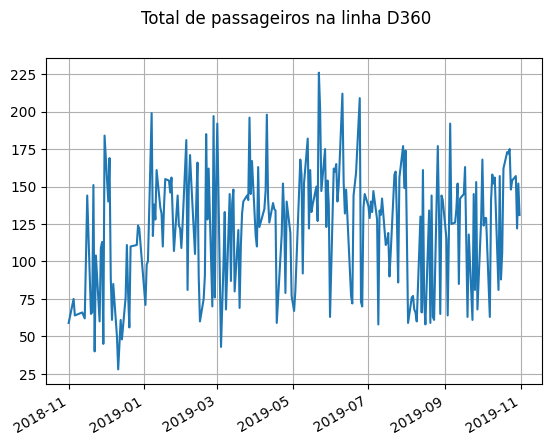

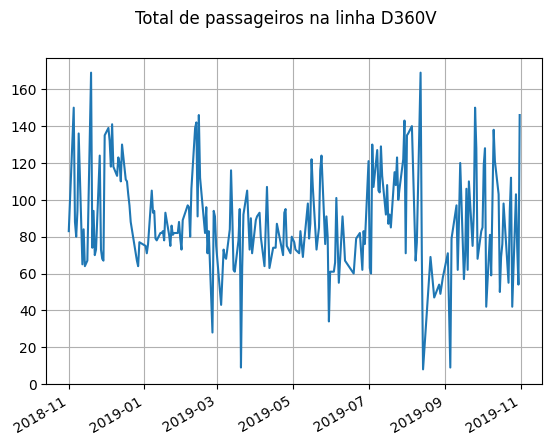

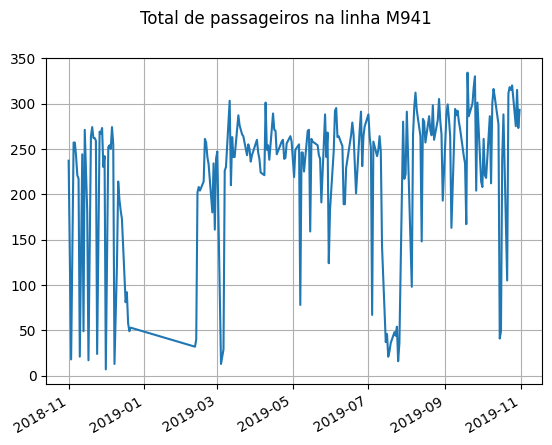

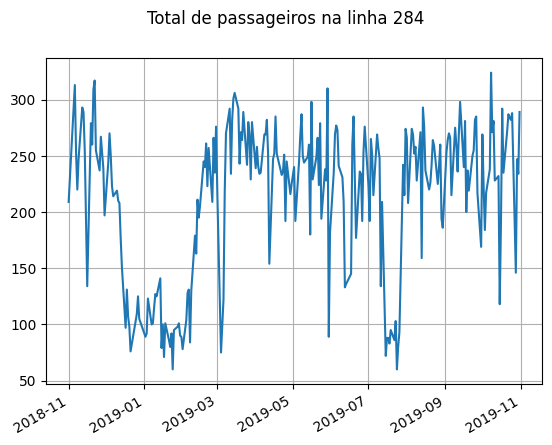

In [145]:
for route in routes_most_ppt:
    sample_data[sample_data.Linha == route][['TotalGiros']].plot(title=f'Total de passageiros na linha {route}', subplots=True, legend=False, xlabel="", grid=True)

There is a clear drop on passengers from December until February, which correlates with end of year festivities and Carnaval.

Also, in some routes there also is a drop after July, probably because of students mid-year break.

Let's see if this stays true for the whole data

In [147]:
aggreg = {
    "Sentido":"count",
    "TotalGiros":"sum",
    "DuracaoMinutes":"mean"
}

data_df = df.groupby("DataIni").agg(aggreg).rename(columns={"Sentido":"NumTrips","DuracaoMinutes":"MeanDuracao"})
data_df['PassPerTrip'] = data_df['TotalGiros']/data_df['NumTrips']
data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2018-11-01 to 2019-11-01
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NumTrips     366 non-null    int64  
 1   TotalGiros   366 non-null    int64  
 2   MeanDuracao  366 non-null    float64
 3   PassPerTrip  366 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 14.3 KB


,NumTrips,TotalGiros,MeanDuracao,PassPerTrip
DataIni,,,,
2018-11-01,8641,168871,32.693554,19.542993
2018-11-02,3319,49890,26.738174,15.031636
2018-11-03,4699,60500,28.051075,12.875080
2018-11-04,3239,41233,26.623341,12.730164
2018-11-05,8838,172403,31.912763,19.507015


array([<Axes: >], dtype=object)

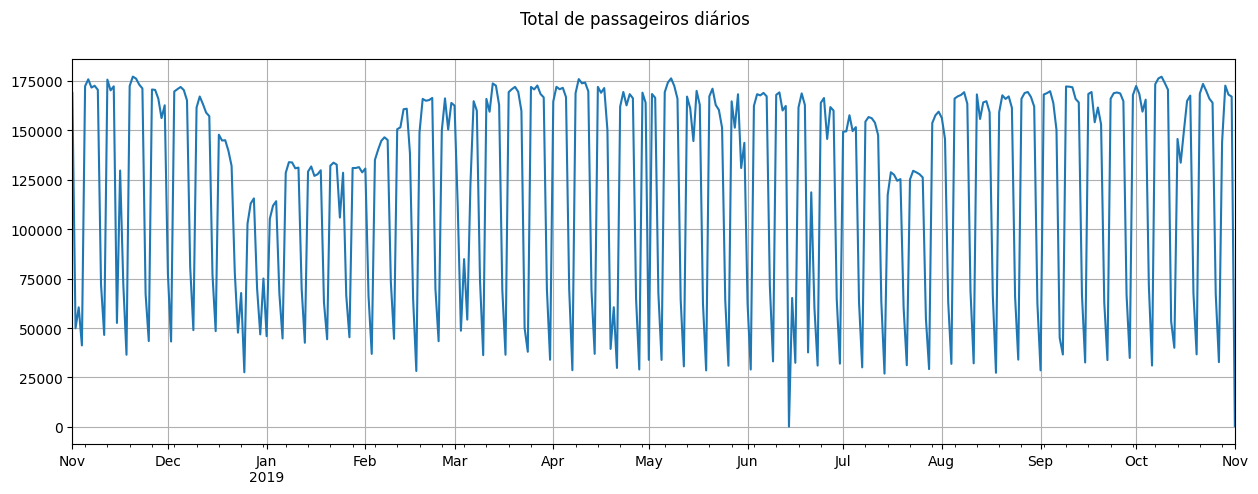

In [187]:
ticks = [t for t in data_df.index if t.day_of_week == 1]
data_df[['TotalGiros']].plot(title=f'Total de passageiros diários', 
                             subplots=True, 
                             legend=False, 
                             xlabel="", 
                             grid=True,
                             figsize=(15,5),
                             #xticks=ticks
                             )

The trend observed in the 5 busiest routes also happens in general. Here we can also see a fluctuation in the number of passengers during the week.

Maybe it's enough to create a model to predict the daily number of passengers.

### Predictive Model

In [229]:
sel_cols = ['NumTrips','TotalGiros','MeanDuracao']
ts = data_df[sel_cols]
ts.info()
ts.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2018-11-01 to 2019-11-01
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NumTrips     366 non-null    int64  
 1   TotalGiros   366 non-null    int64  
 2   MeanDuracao  366 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 11.4 KB


,NumTrips,TotalGiros,MeanDuracao
DataIni,,,
2018-11-01,8641,168871,32.693554
2018-11-02,3319,49890,26.738174
2018-11-03,4699,60500,28.051075
2018-11-04,3239,41233,26.623341
2018-11-05,8838,172403,31.912763


In [232]:
ts['Day'] = ts.index
ts['Day'] = ts.Day.dt.weekday
ts.head()

,NumTrips,TotalGiros,MeanDuracao,Day
DataIni,,,,
2018-11-01,8641,168871,32.693554,3
2018-11-02,3319,49890,26.738174,4
2018-11-03,4699,60500,28.051075,5
2018-11-04,3239,41233,26.623341,6
2018-11-05,8838,172403,31.912763,0


Splitting the data

In [236]:
train_cols = ['NumTrips','MeanDuracao','Day']
target_col = 'TotalGiros'
split_date = '2019-09'

<Axes: xlabel='Data'>

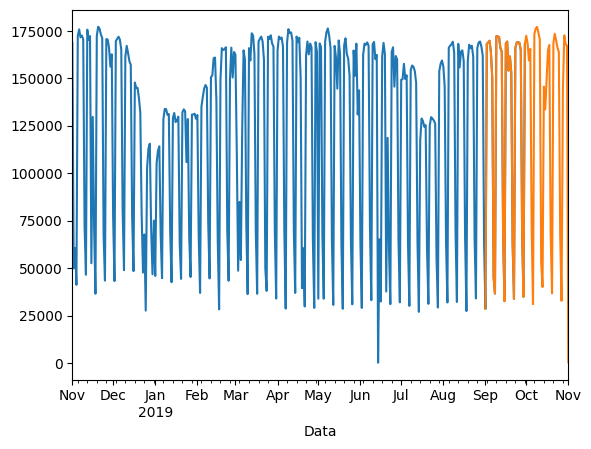

In [240]:
train_data = ts[:split_date]
test_data = ts[split_date:]
pd.concat([train_data[target_col], test_data[target_col]], axis=1, sort=False).plot(legend=False,xlabel="Data")

Train data decomposition

C:\Users\Adm\AppData\Local\Temp\ipykernel_19148\3894925041.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)


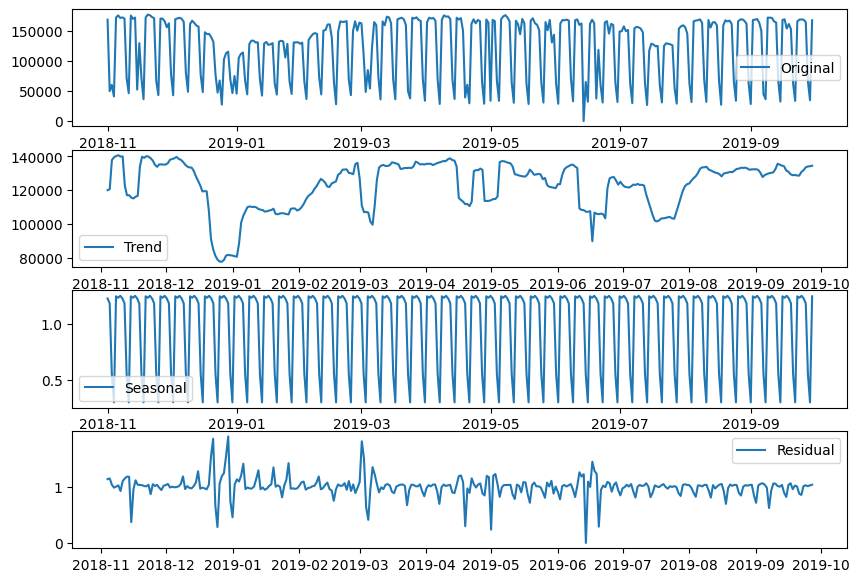

In [248]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_data[target_col], model='multiplicative')
# decomposition = seasonal_decompose(train_data[target_col], model='additive')

# define os componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plots
plt.subplots(figsize=(10, 7))
plt.subplot(411)
plt.plot(train_data[target_col], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

There is a slight upwards trend, while the seasonal pattern is clearer than before.

In [250]:
X_train = train_data[train_cols]
y_train = train_data[target_col]
print(f"Train Variables {X_train.shape} and Target {y_train.shape}")
X_test = test_data[train_cols]
y_test = test_data[target_col]
print(f"Test Variables {X_test.shape} and Target {y_test.shape}")

Train Variables (334, 3) and Target (334,)
Test Variables (62, 3) and Target (62,)


### Random Forest

In [251]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import (explained_variance_score,
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import GridSearchCV


 Best hyperparameters:
{'max_depth': 5, 'n_estimators': 500}
Average Score on train set: -3005.020 +/- 680.249
Average Score on validation set: -6979.397 +/- 2795.063


<BarContainer object of 2 artists>

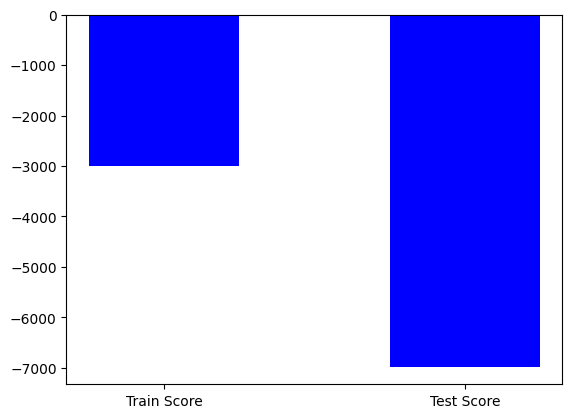

In [267]:
from sklearn.model_selection import TimeSeriesSplit

params = {'n_estimators': [100, 500],
          'max_depth': [5, 10]}

random_forest = RandomForestRegressor()
cross_val = TimeSeriesSplit(n_splits=10)

grid_search = GridSearchCV(random_forest, 
                           param_grid = params, 
                           return_train_score = True,
                           scoring='neg_mean_absolute_error', 
                           cv = cross_val)

grid_search.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(grid_search.best_params_)

cv_results = pd.DataFrame(grid_search.cv_results_)

print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

y = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0], 
     cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
x = ["Train Score", "Test Score"]
width = 1/2
plt.bar(x, y, width, color="blue")

In [268]:
random_forest.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_depth = grid_search.best_params_['max_depth'])

random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
print("MAE train:", mean_absolute_error(y_train, random_forest.predict(X_train)))
print("MAE test:", mean_absolute_error(y_test, y_pred))
print("Mean train value:", y_train.mean())
print("Mean test value:", y_test.mean())

MAE train: 3788.9928198973325
MAE test: 7298.342483243041
Mean train value: 122585.11976047904
Mean test value: 130367.2741935484


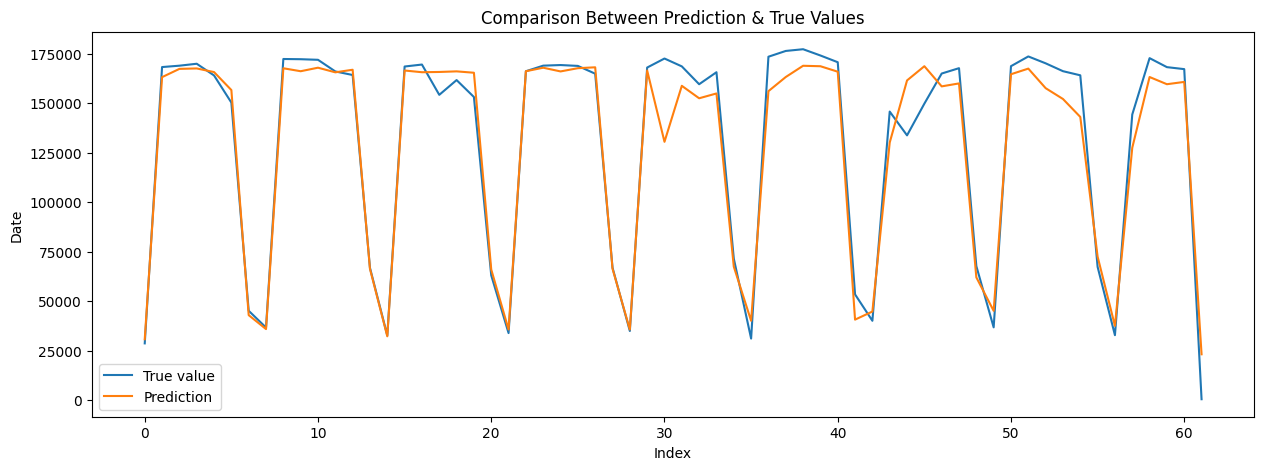

In [263]:
plt.figure(figsize=(15,5))
plt.plot(y_test.reset_index(drop=True), label='True value')
plt.plot(y_pred, label='Prediction')
plt.ylabel("Date")
plt.xlabel("Index")
plt.title("Comparison Between Prediction & True Values")
plt.legend()
plt.show()